# custom paired dataset 구성하기

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1M1kP5ZT975RgxrP_LGLFGhKDePcHW-yL#scrollTo=-MLmtHz_GKFA)

pix2pix 추가 학습에서 봉착한 문제점은 적합한 paired data가 부족하다는 점임

1차 학습시킨 모델(pix2pix_v1(100epoch))에 input으로 <선이 명료한 일러스트레이션 위주의 이미지(1)>를 넣어 output으로 <스케치(2)>를 받아, 
<(1)의 이미지를 noise+blur & noise+dilate 처리한 이미지>와 <스케치(2)> 로 구성된 새로운 데이터셋을 제작함.

(1)의 일러스트레이션 데이터는 2.crawl_images_ipynb에서 크롤링한 6200장의 이미지 데이터를 활용, 약 10000개의 paired data를 구축.

# 1. pix2pix 1차 학습시킨 모델 불러오기

### 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 라이브러리와 모델 정의

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image




# U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x


# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
            nn.Tanh(),
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

transforms_ = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


### 모델 불러오기

In [3]:
%cd /content/drive/MyDrive/pix2pix/trained_model

generator = GeneratorUNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

generator.load_state_dict(torch.load("Pix2Pix_Generator_V1(100e).pt"))
discriminator.load_state_dict(torch.load("Pix2Pix_Discriminator_V1(100e).pt"))

generator.eval();
discriminator.eval();

/content/drive/MyDrive/pix2pix/trained_model


# 2. custom data를 위한 원본 이미지 불러오기

zip파일로 구글 드라이브에 업로드해, /content/에 압축을 풀고 진행함(크롤링을 나눠 진행해 두개의 파일)


In [ ]:
%cd /content/

!unzip '/content/drive/MyDrive/crawl_images.zip' -d '/content/'
!unzip '/content/drive/MyDrive/crawl_images2.zip' -d '/content/'

# 3. 새 데이터셋 구성하기

### 필요한 라이브러리와 함수 정의

In [5]:
from __future__ import print_function
import argparse

from torch.autograd import Variable

import PIL.Image
import PIL.ImageTk
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import Image


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = PIL.Image.open(filepath).convert('RGB')
    img = img.resize((256, 256))
    return img


def save_img(image_tensor, filename):
    image_numpy = image_tensor.float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    image_numpy = image_numpy.astype(np.uint8)
    image_pil = Image.fromarray(image_numpy)
    image_pil.save(filename)
    print("Image saved as {}".format(filename))


parser = argparse.ArgumentParser()
parser.add_argument('--dataset', required=False, default='photo', help='photo')
parser.add_argument('--model', required=False, type=str, default='Pix2Pix_Generator_V1(100e).pt', help='model file to use')
parser.add_argument('--cuda', action='store_true', default=True, help='use cuda')
params = parser.parse_args([])
print(params)

Namespace(cuda=True, dataset='photo', model='Pix2Pix_Generator_V1(100e).pt')


In [6]:
# 이미지에 노이즈 추가하는 함수 정의

import random
 
def add_noise(img):
    row , col = img.shape
     
    number_of_pixels = random.randint(300, 10000)
    for i in range(number_of_pixels):
       
        y_coord=random.randint(0, row - 1)
        x_coord=random.randint(0, col - 1)

        img[y_coord][x_coord] = 255
         
    number_of_pixels = random.randint(300 , 10000)
    for i in range(number_of_pixels):
       
        y_coord=random.randint(0, row - 1)
        x_coord=random.randint(0, col - 1)
         
        img[y_coord][x_coord] = 0
         
    return img
 

### 결과물로 나오는 paired data 예시 확인

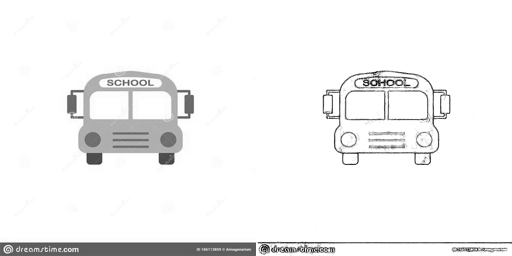

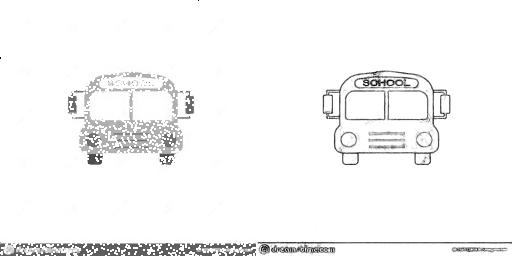

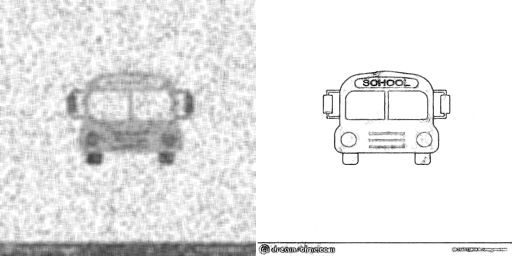

In [7]:
# 이미지 파일 하나 넣어보기

imgs = load_img('/content/content/crawl_images2/bus/001_2635714b.jpg') #인풋 이미지 경로
imgs = transforms_(imgs)

input = Variable(imgs).view(1,-1,256,256)
input_img = input.data[0]

if params.cuda:
    generator = generator.cuda() 
    input = input.cuda()

out = generator(input) #pix2pix_v1 모델 사용
out = out.cpu()
out_img = out.data[0]
save_image(out_img, "out.png", nrow=1, normalize=True)
out_img = cv2.imread("out.png", cv2.IMREAD_GRAYSCALE)

save_image(input_img, "input.png", nrow=1, normalize=True)
input_img = cv2.imread("input.png", cv2.IMREAD_GRAYSCALE)

add_img = np.hstack((input_img, out_img)) #1차학습 모델의 결과 (input 일러스트레이션, output 스케치(도안))

input_img = add_noise(input_img) #input 일러스트레이션에 노이즈 추가

kernel = np.ones((2, 2), 'uint8')
dilate_img = cv2.dilate(input_img, kernel, iterations=1) #dilate 처리한 이미지 생성, dilation 커널(3,3)
add_img1 = np.hstack((dilate_img, out_img)) #(dilate+noise input 일러스트레이션, output 스케치(도안))

avging_img = cv2.blur(input_img,(5,5)) #blur 처리한 이미지 생성
add_img2 = np.hstack((avging_img, out_img)) #(blur+noise input 일러스트레이션, output 스케치(도안))

cv2_imshow(add_img) 
cv2_imshow(add_img1)
cv2_imshow(add_img2)

### [폴더][폴더] 구조에서 개별 파일 일괄 처리

"/content/custom_paired_dataset/" 새 폴더를 지정하고 모든 결과물 업로드.

결과물 전체를 압축해 로컬에 저장.

In [8]:
#[폴더][폴더]구조에서 개별 파일 로드를 위한 '하위폴더/파일이름' 찾기 

image_dir = "/content/content/crawl_images/" #[폴더]로 구성돼 있는 원본 이미지 데이터셋 경로지정
folders = os.listdir(image_dir)

image_filenames = []

for folder in folders:
  target_imagefolder = "/content/content/crawl_images/{}".format(folder)
  image_dir = target_imagefolder.format(params.dataset)
  filenames =  [x for x in os.listdir(image_dir) if is_image_file(x)]
  for filename in filenames:
      new_image_filenames = "{}/{}".format(folder, filename)
      image_filenames.append(new_image_filenames)


print(image_filenames[0:4])

print(len(image_filenames))  #원본 이미지의 수

['dolphin/013_b162696e.jpg', 'dolphin/010_679092e2.jpg', 'dolphin/049_c65a9c1b.jpg', 'dolphin/070_ab37cbe5.jpg']
3699


In [9]:
count = 0

for image_name in image_filenames:
    imgs = load_img("/content/content/crawl_images/{}".format(image_name))
    imgs = transforms_(imgs)

    input = Variable(imgs).view(1,-1,256,256)
    input_img = input.data[0]

    if params.cuda:
        generator = generator.cuda()
        input = input.cuda()

    out = generator(input) #pix2pix_v1 모델 사용
    out = out.cpu()
    out_img = out.data[0]
    save_image(out_img, "out.png", nrow=1, normalize=True)
    out_img = cv2.imread("out.png", cv2.IMREAD_GRAYSCALE)

    save_image(input_img, "input.png", nrow=1, normalize=True)
    input_img = cv2.imread("input.png", cv2.IMREAD_GRAYSCALE)
    input_img = add_noise(input_img) #input 일러스트레이션에 노이즈 추가

    kernel = np.ones((3, 3), 'uint8')
    dilate_img = cv2.dilate(input_img, kernel, iterations=1) #dilate 처리한 이미지 생성, dilation 커널(3,3)
    add_img1 = np.hstack((dilate_img, out_img)) #dilate 처리한 이미지 생성, dilation 커널(3,3)

    avging_img = cv2.blur(input_img,(5,5)) #blur 처리한 이미지 생성
    add_img2 = np.hstack((avging_img, out_img)) #(blur+noise input 일러스트레이션, output 스케치(도안))

    count = count + 1
    real_image_name = "{}.png".format(count)

    cv2.imwrite('/content/custom_paried_dataset/d(1){}'.format(real_image_name), add_img1) #생성한 paired data 저장할 경로
    cv2.imwrite('/content/custom_paired_dataset/b(1){}'.format(real_image_name), add_img2) #생성한 paired data 저장할 경로



In [10]:
#[폴더][폴더]구조에서 개별 파일 로드를 위한 '하위폴더/파일이름' 찾기 

image_dir = "/content/content/crawl_images2/" #[폴더]로 구성돼 있는 원본 이미지 데이터셋 경로지정
folders = os.listdir(image_dir)

image_filenames = []

for folder in folders:
  target_imagefolder = "/content/content/crawl_images2/{}".format(folder)
  image_dir = target_imagefolder.format(params.dataset)
  filenames =  [x for x in os.listdir(image_dir) if is_image_file(x)]
  for filename in filenames:
      new_image_filenames = "{}/{}".format(folder, filename)
      image_filenames.append(new_image_filenames)


print(image_filenames[0:4])

print(len(image_filenames))  #원본 이미지의 수

['flower/042_5a9d4aeb.jpg', 'flower/059_21765c07.jpg', 'flower/099_f803e91d.jpg', 'flower/075_9b82e9f5.jpg']
2500


In [11]:
count = 0

for image_name in image_filenames:
    imgs = load_img("/content/content/crawl_images2/{}".format(image_name))
    imgs = transforms_(imgs)

    input = Variable(imgs).view(1,-1,256,256)
    input_img = input.data[0]

    if params.cuda:
        generator = generator.cuda()
        input = input.cuda()

    out = generator(input) #pix2pix_v1 모델 사용
    out = out.cpu()
    out_img = out.data[0]
    save_image(out_img, "out.png", nrow=1, normalize=True)
    out_img = cv2.imread("out.png", cv2.IMREAD_GRAYSCALE)

    save_image(input_img, "input.png", nrow=1, normalize=True)
    input_img = cv2.imread("input.png", cv2.IMREAD_GRAYSCALE)
    input_img = add_noise(input_img) #input 일러스트레이션에 노이즈 추가

    kernel = np.ones((3, 3), 'uint8')
    dilate_img = cv2.dilate(input_img, kernel, iterations=1) #dilate 처리한 이미지 생성, dilation 커널(3,3)
    add_img1 = np.hstack((dilate_img, out_img)) #dilate 처리한 이미지 생성, dilation 커널(3,3)

    avging_img = cv2.blur(input_img,(5,5)) #blur 처리한 이미지 생성
    add_img2 = np.hstack((avging_img, out_img)) #(blur+noise input 일러스트레이션, output 스케치(도안))

    count = count + 1
    real_image_name = "{}.png".format(count)

    cv2.imwrite('/content/custom_paired_dataset/d(2){}'.format(real_image_name), add_img1) #생성한 paired data 저장할 경로
    cv2.imwrite('/content/custom_paired_dataset/b(2){}'.format(real_image_name), add_img2) #생성한 paired data 저장할 경로


In [17]:
# create zip

ZIP_NAME = "custom_paired_dataset.zip" 

root = "/content/custom_paired_dataset"

!zip -q -r {ZIP_NAME} {root}

In [19]:
# download to your local system

from google.colab import files
files.download(ZIP_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>